<a href="https://colab.research.google.com/github/DJCordhose/ai/blob/master/notebooks/2019_tf/autoencoders_tabular.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoders on Tabular Data

* Losses
   * https://keras.io/losses/
   * Predefined loss functions: https://github.com/keras-team/keras/blob/master/keras/losses.py
   * Example custom loss function: https://stackoverflow.com/questions/43818584/custom-loss-function-in-keras
   * Loss function that is not f(y_true, y_pred): https://github.com/keras-team/keras/issues/2662
* Having more than one input/output, combined losses: https://keras.io/getting-started/functional-api-guide/
* Normalizaing data: https://www.tensorflow.org/api_docs/python/tf/keras/utils/normalize   

In [1]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
print(tf.__version__)

1.12.0


# Loading and exploring our data set

This is a database of customers of an insurance company. Each data point is one customer. The group represents the number of accidents the customer has been involved with in the past

* 0 - red: many accidents
* 1 - green: few or no accidents
* 2 - yellow: in the middle        

In [2]:
!curl -O https://raw.githubusercontent.com/DJCordhose/deep-learning-crash-course-notebooks/master/data/insurance-customers-1500.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 26783  100 26783    0     0   132k      0 --:--:-- --:--:-- --:--:--  132k


In [0]:
import pandas as pd

df = pd.read_csv('./insurance-customers-1500.csv', sep=';')

In [4]:
df.describe()

,speed,age,miles,group
count,1500.000000,1500.000000,1500.000000,1500.000000
mean,122.492667,44.980667,30.434000,0.998667
std,17.604333,17.130400,15.250815,0.816768
min,68.000000,16.000000,1.000000,0.000000
25%,108.000000,32.000000,18.000000,0.000000
50%,120.000000,42.000000,29.000000,1.000000
75%,137.000000,55.000000,42.000000,2.000000
max,166.000000,100.000000,84.000000,2.000000


In [5]:
df.head()

,speed,age,miles,group
0,98.0,44.0,25.0,1
1,118.0,54.0,24.0,1
2,111.0,26.0,34.0,0
3,97.0,25.0,10.0,2
4,114.0,38.0,22.0,1


In [6]:
sns.pairplot?

Object `sns.pairplot` not found.


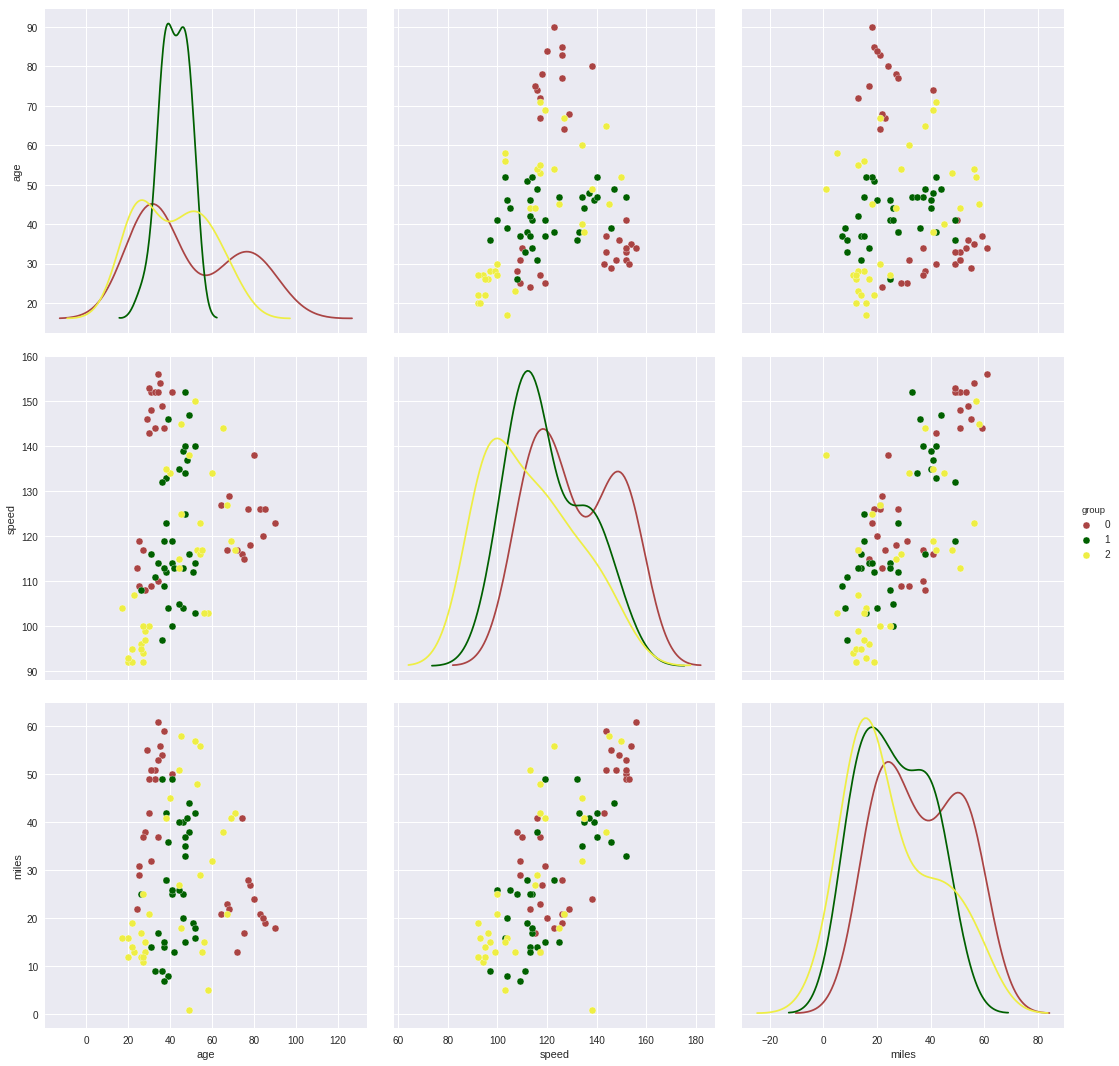

In [7]:
import seaborn as sns

sample_df = df.sample(n=100, random_state=42)
sns.pairplot(sample_df, 
             hue="group", palette={0: '#AA4444', 1: '#006000', 2: '#EEEE44'},
#              kind='reg',
             size=5,
             diag_kind='kde',
             vars=['age', 'speed', 'miles'])

In [8]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Flatten, GlobalAveragePooling1D, Dense
from tensorflow.keras.models import Sequential, Model

encoding_dim = 32

input_data = Input(shape=(4,))
encoded = Dense(units=encoding_dim, activation='relu', name="encoder")(input_data)
decoded = Dense(units=4, activation='linear', name="decoder")(encoded)

autoencoder = Model(inputs=input_data, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary();

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
encoder (Dense)              (None, 32)                160       
_________________________________________________________________
decoder (Dense)              (None, 4)                 132       
Total params: 292
Trainable params: 292
Non-trainable params: 0
_________________________________________________________________


In [9]:
X = df
BATCH_SIZE = 2
%time history = autoencoder.fit(X, X, epochs=10, batch_size=BATCH_SIZE, shuffle=True, verbose=1)

Epoch 1/10
1500/1500 [==============================] - 3s 2ms/step - loss: 421.8827
Epoch 2/10
1500/1500 [==============================] - 3s 2ms/step - loss: 1.8167
Epoch 3/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3998
Epoch 4/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.2495
Epoch 5/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.1494
Epoch 6/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0878
Epoch 7/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0562
Epoch 8/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0371
Epoch 9/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0284
Epoch 10/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0204
CPU times: user 32.2 s, sys: 4.81 s, total: 37 s
Wall time: 26.5 s


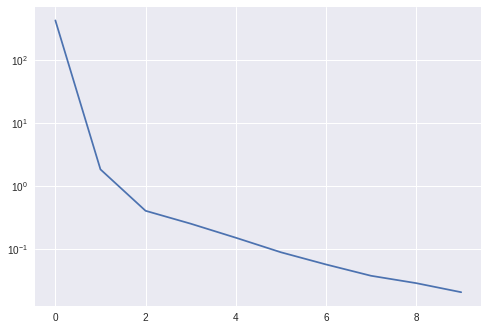

In [10]:
import matplotlib.pyplot as plt

plt.yscale('log')
plt.plot(history.history['loss'])

In [11]:
autoencoder.evaluate(X, X, batch_size=BATCH_SIZE)

1500/1500 [==============================] - 1s 752us/step


0.009633435881580226

In [12]:
samples = df.sample(10).reset_index(drop=True)
samples

,speed,age,miles,group
0,108.0,73.0,14.0,0
1,122.0,25.0,8.0,0
2,133.0,44.0,36.0,1
3,137.0,40.0,47.0,1
4,91.0,27.0,17.0,2
5,100.0,29.0,59.0,2
6,115.0,29.0,33.0,0
7,139.0,46.0,34.0,1
8,99.0,34.0,31.0,1
9,116.0,32.0,26.0,0


In [13]:
predictions = pd.DataFrame(autoencoder.predict(samples), columns=["speed",	"age",	"miles",	"group"])
predictions

,speed,age,miles,group
0,108.008820,72.892822,13.984183,-0.006698
1,122.011116,24.983749,7.975008,-0.000620
2,132.973801,43.880394,35.977631,0.988693
3,136.978348,39.879368,46.979515,0.988237
4,91.042732,27.013742,16.994432,1.994777
5,100.060059,28.980553,59.004818,1.991149
6,115.047218,28.988462,32.988312,-0.001235
7,138.956589,45.859879,33.973343,0.987455
8,99.054726,33.994949,30.995785,0.996153
9,116.035866,31.978769,25.985044,-0.001600


In [14]:
samples.subtract(predictions)

,speed,age,miles,group
0,-0.008820,0.107178,0.015817,0.006698
1,-0.011116,0.016251,0.024992,0.000620
2,0.026199,0.119606,0.022369,0.011307
3,0.021652,0.120632,0.020485,0.011763
4,-0.042732,-0.013742,0.005568,0.005223
5,-0.060059,0.019447,-0.004818,0.008851
6,-0.047218,0.011538,0.011688,0.001235
7,0.043411,0.140121,0.026657,0.012545
8,-0.054726,0.005051,0.004215,0.003847
9,-0.035866,0.021231,0.014956,0.001600


## Looks quite nice, but how impressed are you by abstracting 4 variables into 32?

Let us try dimension of 2

Epoch 1/10
1500/1500 [==============================] - 3s 2ms/step - loss: 3706.4616
Epoch 2/10
1500/1500 [==============================] - 3s 2ms/step - loss: 2355.9309
Epoch 3/10
1500/1500 [==============================] - 3s 2ms/step - loss: 1509.7182
Epoch 4/10
1500/1500 [==============================] - 3s 2ms/step - loss: 956.1105
Epoch 5/10
1500/1500 [==============================] - 3s 2ms/step - loss: 596.3917
Epoch 6/10
1500/1500 [==============================] - 3s 2ms/step - loss: 380.9357
Epoch 7/10
1500/1500 [==============================] - 3s 2ms/step - loss: 270.3717
Epoch 8/10
1500/1500 [==============================] - 3s 2ms/step - loss: 225.1573
Epoch 9/10
1500/1500 [==============================] - 3s 2ms/step - loss: 211.9266
Epoch 10/10
1500/1500 [==============================] - 3s 2ms/step - loss: 209.4090
CPU times: user 32.6 s, sys: 4.3 s, total: 36.9 s
Wall time: 26.3 s


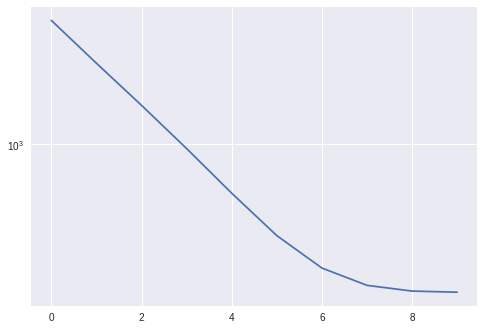

In [15]:
encoding_dim = 2

input_data = Input(shape=(4,))
# notice tanh
encoded = Dense(units=encoding_dim, activation='tanh', name="encoder")(input_data)
decoded = Dense(units=4, activation='linear', name="decoder")(encoded)

autoencoder = Model(inputs=input_data, outputs=decoded)
# this does not get much better than 210 as a loss (bad), so we can just as well get there a bit faster (10 instead of 50 epochs with standard lr)
adam = keras.optimizers.Adam(lr=0.01)
# adam = keras.optimizers.Adam()
autoencoder.compile(optimizer=adam, loss='mse')
BATCH_SIZE = 2
%time history = autoencoder.fit(X, X, epochs=10, batch_size=BATCH_SIZE, shuffle=True, verbose=1)
plt.yscale('log')
plt.plot(history.history['loss'])

In [16]:
autoencoder.evaluate(X, X, batch_size=BATCH_SIZE)

1500/1500 [==============================] - 1s 780us/step


209.0876815210978

In [17]:
# just average over all of them :D
predictions = pd.DataFrame(autoencoder.predict(samples), columns=["speed",	"age",	"miles",	"group"])
predictions

,speed,age,miles,group
0,122.157516,45.300255,30.708887,0.970163
1,122.157516,45.300255,30.708887,0.970163
2,122.157516,45.300255,30.708887,0.970163
3,122.157516,45.300255,30.708887,0.970163
4,122.157516,45.300255,30.708887,0.970163
5,122.157516,45.300255,30.708887,0.970163
6,122.157516,45.300255,30.708887,0.970163
7,122.157516,45.300255,30.708887,0.970163
8,122.157516,45.300255,30.708887,0.970163
9,122.157516,45.300255,30.708887,0.970163


In [18]:
samples.describe()

,speed,age,miles,group
count,10.000000,10.000000,10.000000,10.000000
mean,116.000000,37.900000,30.500000,0.800000
std,16.766368,14.270794,15.327898,0.788811
min,91.000000,25.000000,8.000000,0.000000
25%,102.000000,29.000000,19.250000,0.000000
50%,115.500000,33.000000,32.000000,1.000000
75%,130.250000,43.000000,35.500000,1.000000
max,139.000000,73.000000,59.000000,2.000000


### relu makes it train

Epoch 1/10
1500/1500 [==============================] - 5s 4ms/step - loss: 2166.5098
Epoch 2/10
1500/1500 [==============================] - 5s 3ms/step - loss: 226.4697
Epoch 3/10
1500/1500 [==============================] - 5s 3ms/step - loss: 180.2871
Epoch 4/10
1500/1500 [==============================] - 5s 3ms/step - loss: 150.9254
Epoch 5/10
1500/1500 [==============================] - 5s 3ms/step - loss: 132.8012
Epoch 6/10
1500/1500 [==============================] - 5s 3ms/step - loss: 121.5160
Epoch 7/10
1500/1500 [==============================] - 5s 3ms/step - loss: 115.7569
Epoch 8/10
1500/1500 [==============================] - 5s 3ms/step - loss: 114.1016
Epoch 9/10
1500/1500 [==============================] - 5s 3ms/step - loss: 113.4699
Epoch 10/10
1500/1500 [==============================] - 5s 3ms/step - loss: 113.4332
CPU times: user 1min 3s, sys: 8.43 s, total: 1min 11s
Wall time: 50.8 s


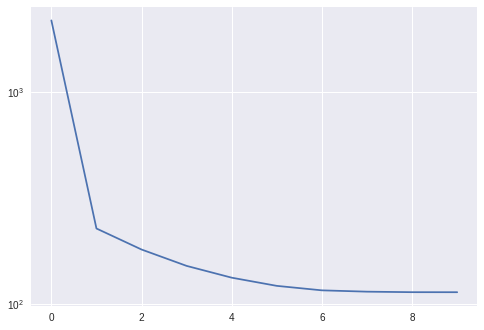

In [19]:
encoding_dim = 2

input_data = Input(shape=(4,))
# notice relu
encoded = Dense(units=encoding_dim, activation='relu', name="encoder")(input_data)
decoded = Dense(units=4, activation='linear', name="decoder")(encoded)

autoencoder = Model(inputs=input_data, outputs=decoded)
# adam = keras.optimizers.Adam(lr=0.01)
adam = keras.optimizers.Adam()
autoencoder.compile(optimizer=adam, loss='mse')
BATCH_SIZE = 1
%time history = autoencoder.fit(X, X, epochs=10, batch_size=BATCH_SIZE, shuffle=True, verbose=1)
plt.yscale('log')
plt.plot(history.history['loss'])

In [20]:
samples

,speed,age,miles,group
0,108.0,73.0,14.0,0
1,122.0,25.0,8.0,0
2,133.0,44.0,36.0,1
3,137.0,40.0,47.0,1
4,91.0,27.0,17.0,2
5,100.0,29.0,59.0,2
6,115.0,29.0,33.0,0
7,139.0,46.0,34.0,1
8,99.0,34.0,31.0,1
9,116.0,32.0,26.0,0


In [21]:
# all groups close to 1, all off as they might not add to a big error
predictions = pd.DataFrame(autoencoder.predict(samples), columns=["speed",	"age",	"miles",	"group"])
predictions

,speed,age,miles,group
0,115.295837,42.171185,30.181902,0.865202
1,110.665154,40.496929,28.900557,0.848639
2,131.742264,48.117508,34.732746,0.924026
3,136.230042,49.740093,35.974545,0.940077
4,88.454628,32.466553,22.754740,0.769199
5,105.772697,38.728024,27.546778,0.831141
6,111.836075,40.920284,29.224558,0.852827
7,136.753357,49.929306,36.119354,0.941949
8,100.083786,36.671158,25.972614,0.810793
9,111.985443,40.974289,29.265890,0.853362


### Let's try normalizing the data first (caution: losses do not compare any more)

In [22]:
df = pd.read_csv('./insurance-customers-1500.csv', sep=';')
normalized_df = (df - df.mean()) / df.std()
normalized_df.head()

,speed,age,miles,group
0,-1.391286,-0.057247,-0.356309,0.001632
1,-0.255202,0.526510,-0.421879,0.001632
2,-0.652832,-1.108011,0.233824,-1.222706
3,-1.448090,-1.166386,-1.339863,1.225971
4,-0.482419,-0.407502,-0.553020,0.001632


Epoch 1/10
1500/1500 [==============================] - 5s 4ms/step - loss: 0.9834
Epoch 2/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.6479
Epoch 3/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.4850
Epoch 4/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.4129
Epoch 5/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3820
Epoch 6/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3674
Epoch 7/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3604
Epoch 8/10
1500/1500 [==============================] - 5s 4ms/step - loss: 0.3567
Epoch 9/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3547
Epoch 10/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3529
CPU times: user 1min 3s, sys: 8.66 s, total: 1min 11s
Wall time: 51.2 s


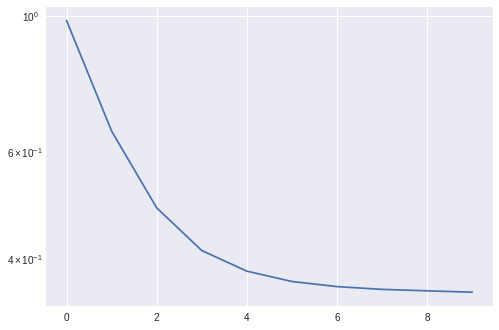

In [23]:
X = normalized_df
encoding_dim = 2

input_data = Input(shape=(4,))
# notice relu
encoded = Dense(units=encoding_dim, activation='relu', name="encoder")(input_data)
decoded = Dense(units=4, activation='linear', name="decoder")(encoded)

autoencoder = Model(inputs=input_data, outputs=decoded)
# adam = keras.optimizers.Adam(lr=0.01)
adam = keras.optimizers.Adam()
autoencoder.compile(optimizer=adam, loss='mse')
BATCH_SIZE = 1
%time history = autoencoder.fit(X, X, epochs=10, batch_size=BATCH_SIZE, shuffle=True, verbose=1)
plt.yscale('log')
plt.plot(history.history['loss'])

## This makes it very hard to estimate how well we did our job, but we can still plot the embedding

Could be interpreted as a fancy version of dimensionality reduction


In [0]:
encoder = Model(inputs=input_data, outputs=encoded)
latent_representation = encoder.predict(X)

In [25]:
latent_representation.shape

(1500, 2)

### Look, ma, clusters

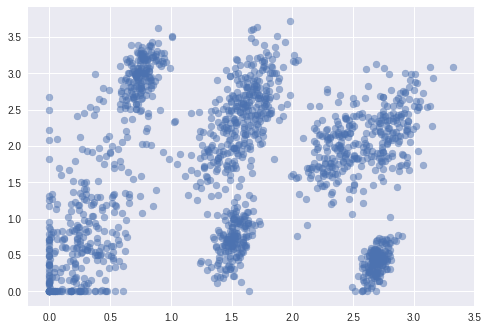

In [26]:
latent_x = latent_representation[:, 0]
latent_y = latent_representation[:, 1]
plt.scatter(latent_x, latent_y, alpha=0.5)

### Clusters have actual meaning

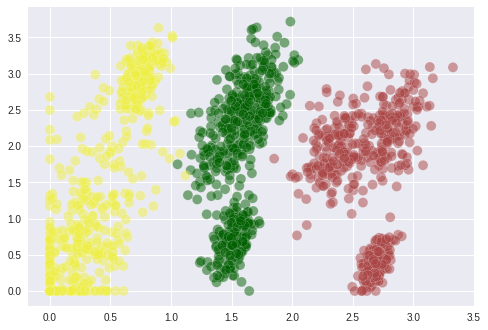

In [27]:
from matplotlib.colors import ListedColormap

# * 0 - red: many accidents
# * 1 - green: few or no accidents
# * 2 - yellow: in the middle
colors = X['group']
color_map = ListedColormap(['#AA4444', '#006000', '#EEEE44'])

plt.scatter(latent_x, latent_y, alpha=0.5, s=100, marker='o', edgecolors='w', cmap=color_map, c=colors)

## But color still was not encoded properly: one-hot

In [0]:
from tensorflow.keras.utils import to_categorical

df = pd.read_csv('./insurance-customers-1500.csv', sep=';')
one_hot_groups = pd.DataFrame(to_categorical(df['group']), columns={'red', 'green', 'yellow'})
main = df.drop('group', axis='columns')

In [29]:
main.head()

,speed,age,miles
0,98.0,44.0,25.0
1,118.0,54.0,24.0
2,111.0,26.0,34.0
3,97.0,25.0,10.0
4,114.0,38.0,22.0


In [30]:
one_hot_groups.head()

,green,red,yellow
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,1.0,0.0,0.0
3,0.0,0.0,1.0
4,0.0,1.0,0.0


### Challenge: we could feed in both parts in a united way, but they need different loss functions

* write a custom loss function that does this and balances the value: https://keras.io/losses/
* create multi-in/out model that makes this a little bit more transparent: https://keras.io/getting-started/functional-api-guide/#multi-input-and-multi-output-models

In [60]:
from tensorflow.keras.layers import concatenate, average, add

# first multi in
main_input = Input(shape=(3,), name='main_input')
group_input = Input(shape=(3,), name='group_input')

# hopefully this balances out inputs to same scale
encoded_main = Dense(units=2, activation='relu', name="main_encoder")(main_input)
encoded_group = Dense(units=2, activation='relu', name="group_encoder")(group_input)

# latent representation

merged = concatenate([encoded_main, encoded_group])
# this might work as well
# merged = average([encoded_main, encoded_group])

# the effective latent encoding
encoding_dim = 2
encoded = Dense(units=encoding_dim, activation='relu', name="encoder")(merged)

# then multi out

main_output = Dense(units=3, activation='linear', name="main_output")(encoded)
group_output = Dense(units=3, activation='softmax', name="group_output")(encoded)

autoencoder = Model(inputs=[main_input, group_input], outputs=[main_output, group_output])

adam = keras.optimizers.Adam(lr=0.01)
# adam = keras.optimizers.Adam()

autoencoder.compile(optimizer=adam,
              loss={'main_output': 'mse', 'group_output': 'categorical_crossentropy'},
              loss_weights={'main_output': 1., 'group_output': 5000.})

autoencoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 3)            0                                            
__________________________________________________________________________________________________
group_input (InputLayer)        (None, 3)            0                                            
__________________________________________________________________________________________________
main_encoder (Dense)            (None, 2)            8           main_input[0][0]                 
__________________________________________________________________________________________________
group_encoder (Dense)           (None, 2)            8           group_input[0][0]                
__________________________________________________________________________________________________
concatenat

In [61]:
BATCH_SIZE = 1
EPOCHS=10

%time history = autoencoder.fit(\
    x={'main_input': main, 'group_input': one_hot_groups},\
    y={'main_output': main, 'group_output': one_hot_groups},\
    epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=True, verbose=1)

Epoch 1/10
1500/1500 [==============================] - 11s 7ms/step - loss: 8817.3581 - main_output_loss: 5129.8288 - group_output_loss: 0.7375
Epoch 2/10
1500/1500 [==============================] - 10s 7ms/step - loss: 4325.2636 - main_output_loss: 2798.2440 - group_output_loss: 0.3054
Epoch 3/10
1500/1500 [==============================] - 10s 7ms/step - loss: 2122.0534 - main_output_loss: 1822.4742 - group_output_loss: 0.0599
Epoch 4/10
1500/1500 [==============================] - 10s 7ms/step - loss: 1645.1927 - main_output_loss: 1496.1352 - group_output_loss: 0.0298
Epoch 5/10
1500/1500 [==============================] - 10s 7ms/step - loss: 1329.5706 - main_output_loss: 1246.9154 - group_output_loss: 0.0165
Epoch 6/10
1500/1500 [==============================] - 10s 7ms/step - loss: 1091.4763 - main_output_loss: 1041.0730 - group_output_loss: 0.0101
Epoch 7/10
1500/1500 [==============================] - 10s 7ms/step - loss: 905.4914 - main_output_loss: 874.2242 - group_output_

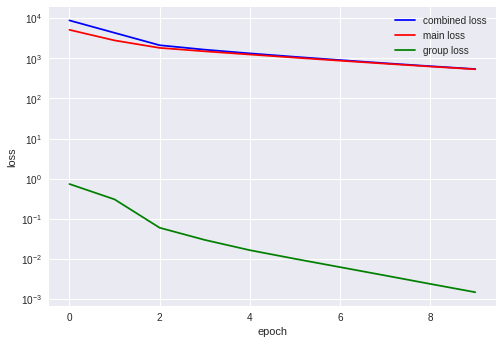

In [62]:
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')

plt.plot(history.history['loss'], 'b')
plt.plot(history.history['main_output_loss'], 'r')
plt.plot(history.history['group_output_loss'], 'g')

plt.legend(['combined loss', 'main loss', 'group loss'], loc='upper right')


In [0]:
samples = df.sample(10).reset_index(drop=True)
main_samples = samples.drop('group', axis='columns')
group_samples = pd.DataFrame(to_categorical(samples['group']), columns={'red', 'green', 'yellow'})

In [64]:
merged_samples = pd.concat([main_samples, group_samples], axis=1)
merged_samples

,speed,age,miles,green,red,yellow
0,138.0,49.0,1.0,0.0,0.0,1.0
1,95.0,21.0,20.0,0.0,0.0,1.0
2,153.0,37.0,53.0,1.0,0.0,0.0
3,103.0,56.0,15.0,0.0,0.0,1.0
4,98.0,29.0,8.0,0.0,0.0,1.0
5,116.0,56.0,38.0,0.0,0.0,1.0
6,116.0,76.0,21.0,1.0,0.0,0.0
7,120.0,55.0,60.0,0.0,0.0,1.0
8,122.0,70.0,23.0,1.0,0.0,0.0
9,118.0,28.0,1.0,0.0,1.0,0.0


In [65]:
autoencoder.predict([main_samples, group_samples])

[array([[127.27589 ,  44.12092 ,  29.585054],
        [127.27589 ,  44.12092 ,  29.585054],
        [ 87.250755,  43.272404,  30.88058 ],
        [127.27589 ,  44.12092 ,  29.585054],
        [127.27589 ,  44.12092 ,  29.585054],
        [127.27589 ,  44.12092 ,  29.585054],
        [ 87.250755,  43.272404,  30.88058 ],
        [127.27589 ,  44.12092 ,  29.585054],
        [ 87.250755,  43.272404,  30.88058 ],
        [110.25412 ,  43.760067,  30.136011]], dtype=float32),
 array([[1.14254470e-14, 2.27611419e-03, 9.97723877e-01],
        [1.14254470e-14, 2.27611419e-03, 9.97723877e-01],
        [9.99747336e-01, 2.52694823e-04, 1.32577495e-14],
        [1.14254470e-14, 2.27611419e-03, 9.97723877e-01],
        [1.14254470e-14, 2.27611419e-03, 9.97723877e-01],
        [1.14254470e-14, 2.27611419e-03, 9.97723877e-01],
        [9.99747336e-01, 2.52694823e-04, 1.32577495e-14],
        [1.14254470e-14, 2.27611419e-03, 9.97723877e-01],
        [9.99747336e-01, 2.52694823e-04, 1.32577495e-14],
 

In [0]:
encoder = Model(inputs=[main_input, group_input], outputs=encoded)
latent_representation = encoder.predict(x={'main_input': main, 'group_input': one_hot_groups})

In [67]:
latent_representation.shape

(1500, 2)

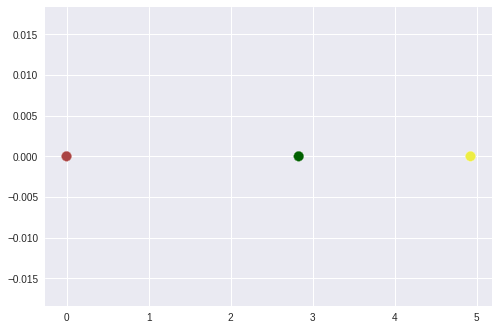

In [68]:
from matplotlib.colors import ListedColormap

# * 0 - red: many accidents
# * 1 - green: few or no accidents
# * 2 - yellow: in the middle
colors = X['group']
color_map = ListedColormap(['#AA4444', '#006000', '#EEEE44'])

latent_x = latent_representation[:, 0]
latent_y = latent_representation[:, 1]

plt.scatter(latent_x, latent_y, alpha=0.5, s=100, marker='o', edgecolors='w', cmap=color_map, c=colors)

### What a funny result: trained to (sometims almost) perfectly reproduce the groups, but not much of anything else

quite obviously we ware emphasizing the group loss way too much

## Making results more stable

* when you visualize latent spaces they should not change much when re-training or fitting additional data points
* when working with autoencoders or embeddings there are two ways to make that happen
  1. save model, do not retrain from scratch and only fit new data points with low learning rate
  1. save output from embedding and keep new latent space similar by adding to the loss function

### Option I: Saving and reloading model, retrain
* https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model

In [0]:
# save complete model
autoencoder.save('autoencoder-v1.h5')
del autoencoder

In [0]:
# later...
from tensorflow.keras.models import load_model
autoencoder = load_model('autoencoder-v1.h5')

In [0]:
main_input = autoencoder.get_layer('main_input').input
group_input = autoencoder.get_layer('group_input').input
encode = autoencoder.get_layer('encoder').output

In [0]:
encoder = Model(inputs=[main_input, group_input], outputs=encode)

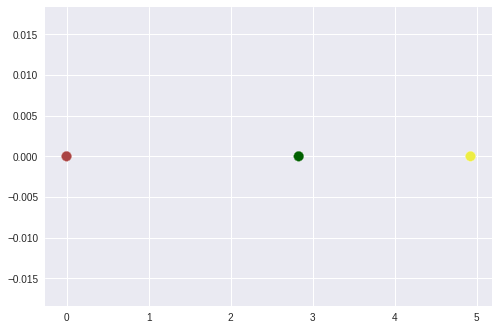

In [73]:
latent_representation = encoder.predict(x={'main_input': main, 'group_input': one_hot_groups})
colors = X['group']
color_map = ListedColormap(['#AA4444', '#006000', '#EEEE44'])

latent_x = latent_representation[:, 0]
latent_y = latent_representation[:, 1]

plt.scatter(latent_x, latent_y, alpha=0.5, s=100, marker='o', edgecolors='w', cmap=color_map, c=colors)

### Using new dataset

In [74]:
!curl -O https://raw.githubusercontent.com/DJCordhose/deep-learning-crash-course-notebooks/master/data/insurance-customers-300.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5376  100  5376    0     0  28903      0 --:--:-- --:--:-- --:--:-- 28903


In [0]:
import pandas as pd

new_df = pd.read_csv('./insurance-customers-300.csv', sep=';')
new_one_hot_groups = pd.DataFrame(to_categorical(new_df['group']), columns={'red', 'green', 'yellow'})
new_main = new_df.drop('group', axis='columns')

In [76]:
new_main.head()

,speed,age,miles
0,117.0,41.0,5.0
1,108.0,18.0,15.0
2,107.0,28.0,14.0
3,111.0,43.0,62.0
4,129.0,36.0,42.0


In [77]:
new_one_hot_groups.head()

,green,red,yellow
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,0.0,0.0,1.0
3,0.0,0.0,1.0
4,1.0,0.0,0.0


In [84]:
# adam = keras.optimizers.Adam()
# even this high learning rate can not break it (moves it quite a bit, but still same overall shape)
adam = keras.optimizers.Adam(lr=0.01)

autoencoder.compile(optimizer=adam,
              loss={'main_output': 'mse', 'group_output': 'categorical_crossentropy'},
              loss_weights={'main_output': 1., 'group_output': 5000.})

BATCH_SIZE = 1
EPOCHS=10

%time history = autoencoder.fit(\
    x={'main_input': new_main, 'group_input': new_one_hot_groups},\
    y={'main_output': new_main, 'group_output': new_one_hot_groups},\
    epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=True, verbose=1)


Epoch 1/10
300/300 [==============================] - 3s 10ms/step - loss: 484.8726 - main_output_loss: 479.1427 - group_output_loss: 0.0011
Epoch 2/10
300/300 [==============================] - 2s 7ms/step - loss: 468.1991 - main_output_loss: 463.6383 - group_output_loss: 9.1215e-04
Epoch 3/10
300/300 [==============================] - 2s 7ms/step - loss: 453.1287 - main_output_loss: 448.8594 - group_output_loss: 8.5386e-04
Epoch 4/10
300/300 [==============================] - 2s 7ms/step - loss: 439.4036 - main_output_loss: 435.9194 - group_output_loss: 6.9684e-04
Epoch 5/10
300/300 [==============================] - 2s 7ms/step - loss: 426.6812 - main_output_loss: 423.1446 - group_output_loss: 7.0733e-04
Epoch 6/10
300/300 [==============================] - 2s 7ms/step - loss: 414.4767 - main_output_loss: 411.7369 - group_output_loss: 5.4796e-04
Epoch 7/10
300/300 [==============================] - 2s 7ms/step - loss: 402.7761 - main_output_loss: 400.2125 - group_output_loss: 5.1272

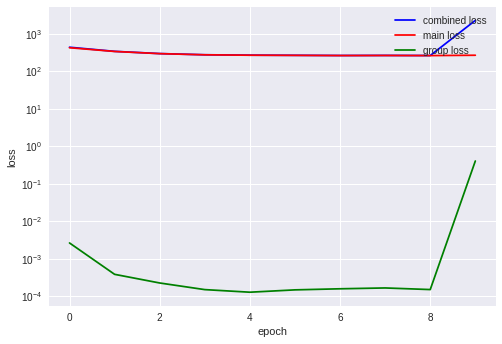

In [79]:
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')

plt.plot(history.history['loss'], 'b')
plt.plot(history.history['main_output_loss'], 'r')
plt.plot(history.history['group_output_loss'], 'g')

plt.legend(['combined loss', 'main loss', 'group loss'], loc='upper right')


In [0]:
main_input = autoencoder.get_layer('main_input').input
group_input = autoencoder.get_layer('group_input').input
encode = autoencoder.get_layer('encoder').output
encoder = Model(inputs=[main_input, group_input], outputs=encode)

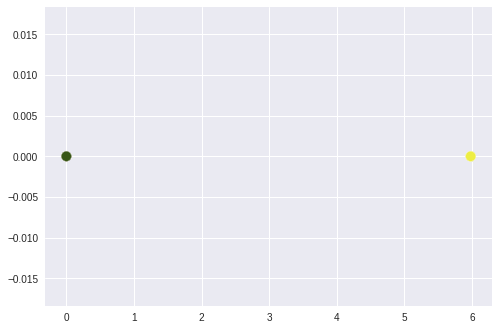

In [81]:
latent_representation = encoder.predict(x={'main_input': new_main, 'group_input': new_one_hot_groups})
colors = new_df['group']
color_map = ListedColormap(['#AA4444', '#006000', '#EEEE44'])

latent_x = latent_representation[:, 0]
latent_y = latent_representation[:, 1]

plt.scatter(latent_x, latent_y, alpha=0.5, s=100, marker='o', edgecolors='w', cmap=color_map, c=colors)

### Old data

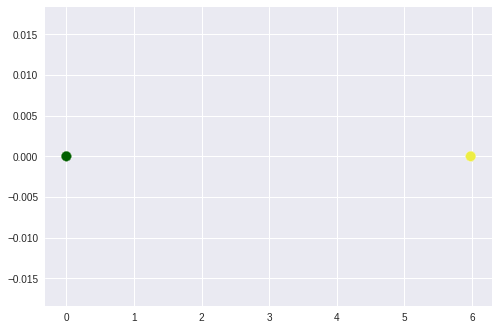

In [82]:
latent_representation = encoder.predict(x={'main_input': main, 'group_input': one_hot_groups})
colors = X['group']
color_map = ListedColormap(['#AA4444', '#006000', '#EEEE44'])

latent_x = latent_representation[:, 0]
latent_y = latent_representation[:, 1]

plt.scatter(latent_x, latent_y, alpha=0.5, s=100, marker='o', edgecolors='w', cmap=color_map, c=colors)

### Option II: Train from scratch, but use difference to original latent representation as part of loss function


In [0]:
# start over from scratch
from tensorflow.keras.models import load_model
autoencoder = load_model('autoencoder-v1.h5')

In [0]:
main_input = autoencoder.get_layer('main_input').input
group_input = autoencoder.get_layer('group_input').input
encode = autoencoder.get_layer('encoder').output
encoder = Model(inputs=[main_input, group_input], outputs=encode)

In [0]:
original_latent_representation = encoder.predict(x={'main_input': new_main, 'group_input': new_one_hot_groups})

In [59]:
original_latent_representation.shape

(300, 2)

In [0]:
# first multi in
main_input = Input(shape=(3,), name='main_input')
group_input = Input(shape=(3,), name='group_input')

# hopefully this balances out inputs to same scale
encoded_main = Dense(units=2, activation='relu', name="main_encoder")(main_input)
encoded_group = Dense(units=2, activation='relu', name="group_encoder")(group_input)

# latent representation

merged = concatenate([encoded_main, encoded_group])
# this might work as well
# merged = average([encoded_main, encoded_group])

# the effective latent encoding
encoding_dim = 2
encoded = Dense(units=encoding_dim, activation='relu', name="encoder")(merged)

# then multi out

main_output = Dense(units=3, activation='linear', name="main_output")(encoded)
group_output = Dense(units=3, activation='softmax', name="group_output")(encoded)

autoencoder = Model(inputs=[main_input, group_input], outputs=[main_output, group_output])


In [0]:
# adam = keras.optimizers.Adam()
# even this high learning rate can not break it (moves it quite a bit, but still same overall shape)
adam = keras.optimizers.Adam(lr=0.1)

autoencoder.compile(optimizer=adam,
              loss={'main_output': 'mse', 'group_output': 'categorical_crossentropy'},
              loss_weights={'main_output': 1., 'group_output': 5000.})

BATCH_SIZE = 1
EPOCHS=10

%time history = autoencoder.fit(\
    x={'main_input': new_main, 'group_input': new_one_hot_groups},\
    y={'main_output': new_main, 'group_output': new_one_hot_groups},\
    epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=True, verbose=1)
